In [79]:
# Last mod: FA 2023 Aug 21 - final cosmetics

# Testing XGBoost ages with other catalogues

First, let's import some libraries:

In [47]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, MaskedColumn, join
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline

import os.path

from time import time
from sklearn import manifold, datasets

from itertools import product
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from utils import running_median, overplot_trend, overplot_representative_errorbars

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 
font = {'family' : 'serif', 'serif': 'helvet', 'weight' : 'bold', 'size'   : 20}
mpl.rc('font', **font)
mpl.rc('text', usetex=True)

### Decide whether to produce comparison plots wrt to calibrated or uncalibrated ages:

In [80]:
calib        = False
suffix       = "_xgb"

if calib:
    agecol = "spec_age"+suffix+"_calib"
else:
    agecol = "spec_age"+suffix
    
#uncertcolu = "spec_age"+suffix+"_sigu"
#uncertcoll = "spec_age"+suffix+"_sigl"
uncertcol  = "spec_age"+suffix+"_uncert"

## Read asteroseismic age data tables

As an anchor for our method, we want asteroseismic ages for red giant stars. 
The most reliable ones are using Kepler + APOGEE data ([Miglio+2021](https://www.aanda.org/articles/aa/full_html/2021/01/aa38307-20/aa38307-20.html)):

In [81]:
miglio2021 = Table.read("../data/kepler_apogee_miglio2021.fit")
miglio2021

APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,b_Age,b_age_lc,Mass,b_Mass,b_mass_lc,Rad,b_Rad,b_rad_lc,Dist,b_Dist,b_dist_lc,Av,b_Av,b_av_lc,evstate,zmax,e_zmax,Ecc,e_Ecc,Rperi,e_Rperi,Rap,e_Rap,GalR,Galphi,GalZ,vR,vT,vZ,_RA,_DE
,,mag,mag,mag,deg,deg,,,Gyr,Gyr,Gyr,solMass,solMass,solMass,solRad,solRad,solRad,kpc,kpc,kpc,mag,mag,mag,,kpc,kpc,,,kpc,kpc,kpc,kpc,kpc,rad,kpc,km / s,km / s,km / s,deg,deg
bytes20,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2M19222920+3710285,1569842,9.589,9.074,8.989,290.6217,37.1746,-0.24,0.12,9.8,7.9,12.6,1.0,0.93,1.06,4.98,4.86,5.08,0.619,0.61,0.629,0.07,-0.01,0.14,1,0.366,0.006,0.112,0.002,6.648,0.019,8.328,0.005,7.933,0.072,0.131,-29.82,209.19,21.51,290.62167,37.17458
2M19300513+3717470,1726291,11.206,10.679,10.547,292.5214,37.2964,-0.34,0.19,10.1,8.0,12.8,0.98,0.92,1.05,4.68,4.56,4.76,1.17,1.152,1.188,0.43,0.35,0.49,1,0.31,0.004,0.168,0.001,7.417,0.014,10.42,0.012,7.812,0.14,0.204,31.83,245.94,10.69,292.52137,37.29639
2M19045380+3741230,2283721,11.266,10.709,10.59,286.2242,37.6897,-0.19,0.11,9.4,7.5,12.0,1.01,0.96,1.09,6.58,6.41,6.7,1.676,1.65,1.701,0.3,0.2,0.35,1,0.493,0.008,0.072,0.001,6.745,0.011,7.798,0.01,7.68,0.198,0.415,-16.38,210.65,-16.16,286.22417,37.68972
2M19060736+3740100,2284679,9.923,9.456,9.335,286.5307,37.6694,-0.45,0.21,11.2,9.0,14.0,0.94,0.89,1.0,3.98,3.89,4.06,0.588,0.58,0.597,0.07,0.0,0.13,1,0.821,0.004,0.844,0.0,0.692,0.003,8.204,0.004,7.934,0.067,0.157,66.53,37.45,-39.19,286.53067,37.66944
2M19280882+3736381,2305590,9.829,9.235,9.128,292.0368,37.6106,-0.3,0.24,10.2,8.3,12.4,1.03,0.95,1.07,8.43,8.28,8.63,1.072,1.059,1.085,0.34,0.28,0.38,1,0.529,0.014,0.587,0.002,2.392,0.006,9.188,0.026,7.835,0.128,0.197,111.85,114.69,27.8,292.03675,37.61058
2M19250117+3742537,2442483,11.509,10.934,10.812,291.2549,37.7149,-0.14,0.12,10.0,7.9,12.7,1.02,0.95,1.08,5.87,5.73,6.0,1.662,1.636,1.688,0.37,0.29,0.45,1,0.338,0.006,0.208,0.002,5.329,0.017,8.135,0.008,7.726,0.201,0.312,43.73,189.59,7.28,291.25487,37.71492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2M19133250+5140282,12598909,11.342,10.776,10.617,288.3854,51.6745,0.16,0.0,11.0,9.7,13.4,1.02,0.97,1.07,7.86,7.7,7.98,1.998,1.975,2.022,0.13,0.09,0.2,1,0.689,0.009,0.202,0.001,5.854,0.009,8.824,0.026,8.1,0.236,0.629,-49.3,194.57,-9.92,288.38542,51.6745


We also have the K2 + GALAH data from [Zinn+2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...926..191Z/abstract):

In [82]:
zinn2022 = Table.read("../data/k2_galah_zinn2022.fits")
zinn2022

EPIC,GALAH,age,e_age,FeH,Teff,MgFe,e_FeH,e_Teff,e_MgFe,sobject_id_1,EDR3_source_id,glon,glat,age05,age16,age50,age84,age95,ageflag,mass16,mass50,mass84,teff16,teff50,teff84,met16,met50,met84,logg16,logg50,logg84,dist05,dist16,dist50,dist84,dist95,AV05,AV16,AV50,AV84,AV95,Xg,Yg,Zg,Rg
int32,int64,float32,float32,float32,int16,float64,float32,int16,float32,int64,bytes100,float32,float32,float32,float32,float32,float32,float32,bytes20,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
220387110,161007003801220,7.7,1.8,-0.18,4691,0.15,0.063,91,0.058,161007003801220,2554396309982001536,116.22801,-58.23026,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.99546677,1.069267,1.2121592,4675.4263,4717.3604,4773.294,-0.19519514,-0.09886605,-0.046779405,2.7061815,2.7450333,2.8056407,0.7124427,0.72190547,0.73900783,0.75657296,0.76765734,-0.1677314,-0.06465694,0.09331309,0.25045037,0.3419845,-8.37195737063698,0.349032658183932,-0.6282829298350185,8.379229917614255
220352927,161007003801158,11.0,1.5,-1.3,4883,0.12,0.11,124,0.12,161007003801158,2553749453547532800,116.2454,-58.934113,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.8113137,0.8462425,0.8778329,4838.175,4879.245,4927.825,-1.2285982,-1.0858957,-0.9742354,2.0896122,2.1566837,2.2354307,1.9977691,2.1256893,2.311502,2.490357,2.6338108,-0.19244775,-0.08978152,0.06709295,0.22286183,0.3285024,-8.727471271577219,1.0698224713058024,-1.9799735706059487,8.792796763050795
220420379,161007003801285,5.2,2.9,-0.6,4705,0.32,0.12,136,0.18,161007003801285,2554552848654332928,117.28564,-57.62667,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.8686563,0.9120761,0.96866316,4681.9077,4754.0786,4901.924,-0.5495246,-0.40926585,-0.26454726,2.328565,2.378746,2.4247105,1.5853473,1.6588559,1.7346382,1.8376716,1.9271879,-0.16861773,-0.061954595,0.10427424,0.27371448,0.38141242,-8.625779351635325,0.825440025173661,-1.465035986731263,8.665184398398976
220329169,161007003801110,4.1,0.74,-0.3,4864,0.12,0.066,95,0.064,161007003801110,2550699786248593792,116.9833,-59.47032,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.95956415,1.0154893,1.1299838,4813.4883,4855.1836,4904.427,-0.29618782,-0.202951,-0.14829238,2.9305604,2.9688995,3.018476,0.6020639,0.61126274,0.62707615,0.6428746,0.6533361,-0.100228734,0.011356348,0.1713531,0.3237294,0.42670974,-8.344533680982613,0.2838678413935867,-0.5401421667601018,8.349360652435053
220425435,161007003801301,9.2,2.7,-1.6,5060,0.11,0.2,174,0.18,161007003801301,2554566906082928896,117.715546,-57.549053,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.79715335,0.8347923,0.8737508,4936.77,5016.359,5094.402,-1.4338722,-1.1897494,-0.9390785,2.2937765,2.351029,2.4067307,1.9291867,1.9917191,2.102193,2.22872,2.3186636,-0.21051358,-0.10805751,0.0471158,0.20430382,0.30969068,-8.724607768204562,0.9985721580317268,-1.7739380588118978,8.781567460528418
220377647,161007003801390,4.2,0.85,-0.4,4995,0.16,0.092,116,0.12,161007003801390,2554156169770546176,118.1675,-58.51864,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.93497425,1.001721,1.170043,4921.083,4974.993,5036.442,-0.40414768,-0.30602524,-0.20757318,3.0901895,3.138089,3.207226,0.764847,0.78239816,0.8098667,0.838986,0.8606932,-0.20250176,-0.101588465,0.05503788,0.21163452,0.3161291,-8.399644247350842,0.3728425639274693,-0.6906625163935549,8.407915024518868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246294910,161106002101303,8.7,2.3,-0.37,4569,0.25,0.07,92,0.073,161106002101303,2447407128450796032,89.771164,-62.16215,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.94316685,0.97760683,1.0276247,4574.388,4607.221,4643.975,-0.29230693,-0.20248318,-0.14781968,2.3881285,2.433921,2.4755273,1.6718314,1.7126739,1.7886218,1.8769522,1.9398276,0.06369984,0.113173395,0.18319097,0.2

The TESS CVZ analysis of [Mackereth+2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.1947M/abstract):

In [83]:
mackereth2021 = Table.read("../data/tess_cvz_mackereth2021.fits")
mackereth2021

source_id,TIC,N_sectors,ra,ra_error,dec,dec_error,l,b,ecl_lon,ecl_lat,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,hmag,jmag,kmag,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,A_K,numax_COR,numax_err_COR,dnu_COR,dnu_err_COR,numax_BHM,numax_err_BHM,dnu_BHM,dnu_err_BHM,numax_A2Z,numax_err_A2Z,dnu_A2Z,dnu_err_A2Z,mean_numax,mean_numax_err,mean_dnu,mean_dnu_err,N_pipelines_mean,seismic_param_gold,logg_HERMES,e_logg_HERMES,Teff_SKYMAPPER,e_Teff_SKYMAPPER,feh_SKYMAPPER,e_feh_SKYMAPPER,ecc_MB2018,ecc_err_MB2018,rperi_MB2018,rperi_err_MB2018,rap_MB2018,rap_err_MB2018,zmax_MB2018,zmax_err_MB2018,APOGEE_ID_APOGEE,FE_H_APOGEE,FE_H_ERR_APOGEE,MG_FE_APOGEE,MG_FE_ERR_APOGEE,LOGG_APOGEE,LOGG_ERR_APOGEE,TEFF_APOGEE,TEFF_ERR_APOGEE,age_PARAM_BHM,age_68L_PARAM_BHM,age_68U_PARAM_BHM,mass_PARAM_BHM,mass_68L_PARAM_BHM,mass_68U_PARAM_BHM,rad_PARAM_BHM,rad_68L_PARAM_BHM,rad_68U_PARAM_BHM,CHI2_gof_PARAM_BHM,mbol_PARAM_BHM_NO_L,mbol_68L_PARAM_BHM_NO_L,mbol_68U_PARAM_BHM_NO_L,age_APO_PARAM_BHM,age_68L_APO_PARAM_BHM,age_68U_APO_PARAM_BHM,mass_APO_PARAM_BHM,mass_68L_APO_PARAM_BHM,mass_68U_APO_PARAM_BHM,rad_APO_PARAM_BHM,rad_68L_APO_PARAM_BHM,rad_68U_APO_PARAM_BHM,CHI2_gof_APO_PARAM_BHM,luminosity_BHM,luminosity_68U_BHM,luminosity_68L_BHM,luminosity_COR,luminosity_68U_COR,luminosity_68L_COR,luminosity_A2Z,luminosity_68U_A2Z,luminosity_68L_A2Z,luminosity_HERMES,luminosity_68L_HERMES,luminosity_68U_HERMES,luminosity_GAIA,luminosity_68L_GAIA,luminosity_68U_GAIA,luminosity_APO_GAIA,luminosity_68L_APO_GAIA,luminosity_68U_APO_GAIA,evstate_MV,evstate_agreement_MV,lum_flag_BHM,lum_flag_COR,lum_flag_A2Z,numax_dnu_consistent,numax_predicted,numax_predicted_err,XGal,YGal,RGal,ZGal
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,kpc,kpc
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,int64,bool,float64,float64,int16,int16,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64
4759266867156545536,149346975,12,83.60831823704378,0.016513296871897606,-61.367357156985165,0.020950273018090767,270.39488656131465,-32.740472162313885,58.713340274750834,-84.10404629877485,0.8345997958314426,0.01842033445434786,2.163634672996713,0.0368518784184908,-2.690981911278145,0.04079146622034934,4.73603117169421,2.5378549005334428,0.0017837603,0.14757405,-0.08866062,0.0038818587,0.24734992,0.070875384,-0.42472336,0.06461448,-0.24970464,-0.084684856,7.799,8.461,7.562,10.39577,11.151597,9.583019,0.019277696641225295,95.59,1.78,8.782,0.02,7.14,0.85,1.25991,0.172391,7.8,0.31,-999.0,-999.0,36.843334,1.9967474,5.020955,0.17354728,3,False,-9999.0,-9999.0,4212,113,0.035,0.157,0.20002664444158158,0.005680813014159833,7.224120866889526,0.050201324655128055,10.827794879270597,0.1834015217838827,0.8620629465213455,0.034179216542717494,--,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,16.046504,12.549988,18.597925,0.895296,0.851009,0.96

The CoRoT + APOGEE data from [Anders+2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A..30A/abstract):

In [84]:
anders2017 = Table.read("../data/corot_apogee_anders2017.fit")
anders2017

CoRoT,APOGEE,RAJ2000,DEJ2000,GLON,GLAT,FIELD,run,Seismic,numax,e_numax,Dnu,e_Dnu,evstat,ASPCAP,File,Tel,Loc,TargFlags,NVisits,SNR,StarFlags,__RV_,sigma,e__RV_,Teff,e_Teff,logg,e_logg,__M_H_,__M_H_A,e__M_H_,__alpha_M_,e__alpha_M_,chi2,ASPCAPFlags,__Al_H_,__Ca_H_,__C_H_,__Fe_H_,__K_H_,__Mg_H_,__Mn_H_,__Na_H_,__Ni_H_,__N_H_,__O_H_,__Si_H_,__S_H_,__Ti_H_,__V_H_,e__Al_H_,e__Ca_H_,e__C_H_,e__Fe_H_,e__K_H_,e__Mg_H_,e__Mn_H_,e__Na_H_,e__Ni_H_,e__N_H_,e__O_H_,e__Si_H_,e__S_H_,e__Ti_H_,e__V_H_,f__Al_H_,f__Ca_H_,f__C_H_,f__Fe_H_,f__K_H_,f__Mg_H_,f__Mn_H_,f__Na_H_,f__Ni_H_,f__N_H_,f__O_H_,f__Si_H_,f__S_H_,f__Ti_H_,f__V_H_,EKs,MetEKs,SFDE_B-V_,RCDist,Visits,BmagO,e_BmagO,VmagO,e_VmagO,RmagO,e_RmagO,ImagO,e_ImagO,AllWISE,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,W1mag,e_W1mag,W2mag,e_W2mag,W3mag,e_W3mag,W4mag,e_W4mag,BmagA,e_BmagA,VmagA,e_VmagA,gmagA,e_gmagA,rmagA,e_rmagA,imagA,e_imagA,RAEdeg,DEEdeg,CCD,WIN,x,y,SpType,LC,Tcol,PPMXL,USNOB1,_2MASS,USNOA2,CMC14,TYCHO2,UCAC2,UCAC4,pmRA,e_pmRA,pmDE,e_pmDE,UCAC4flag,MassS,loggS,RadiusS,AgeM,AgeM68L,AgeM68U,AgeM95L,AgeM95U,eAgeI,eAgee,eAgeT,MassM,MassM68L,MassM68U,MassM95L,MassM95U,RadiusM,RadiusM68L,RadiusM68U,RadiusM95L,RadiusM95U,loggM,loggM68L,loggM68U,loggM95L,loggM95U,DistM,DistM68L,DistM68U,DistM95L,DistM95U,AVM,AVM68L,AVM68U,AVM95L,AVM95U,nfilt,filt,Xg,e_Xg,Yg,e_Yg,Zg,e_Zg,Rg,e_Rg,vT,e_vT,vXg,e_vXg,vYg,e_vYg,vZg,e_vZg,vRg,e_vRg,vPhig,e_vPhig,Rguide,e_Rguide,Simbad
,,deg,deg,deg,deg,,,,muHz,muHz,muHz,muHz,,,,,,,,,,km / s,km / s,km / s,K,K,log(cm.s**-2),log(cm.s**-2),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,mag,kpc,,mag,mag,mag,mag,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,deg,deg,,,,,,,K,,,,,,,,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,solMass,solMass,solMass,solMass,solMass,solRad,solRad,solRad,solRad,solRad,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),pc,pc,pc,pc,pc,mag,mag,mag,mag,mag,,,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,kpc,kpc,
int32,bytes18,float64,float64,float64,float64,bytes7,bytes5,bytes14,float64,float64,float64,float64,bytes5,bytes44,bytes33,bytes6,int16,bytes59,int16,float64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes31,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float64,bytes17,float64,float64,bytes125,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes2,int16,float64,float64,bytes2,bytes3,int16,bytes19,bytes12,bytes16,bytes13,bytes15,int32,int32,bytes10,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,bytes26,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7
100448189,2M19223319+0141341,290.638327,1.692813,38.00855,-6.13865,COROTC,LRc01,automatic fit,16.93,0.624,2.27,0.035,,apogee.apo25m.s.v603.4398.2M19223319+0141341,apStar-r5-2M19223319+0141341.fits,apo25m,4398,"APOGEE_ANCILLARY,APOGEE_DISK_RED_GIANT",3,261.212,,90.061699,0.036332,0.014074,4492.8687,91.466736,2.20127,

In [85]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Mar2023.fits")
chem_age = np.isfinite(dr17_master[agecol])
our_cat = dr17_master[ chem_age ]

## Location in the Galaxy (RGal vs ZGal, XGal vs YGal)

(381, 1244, 3)


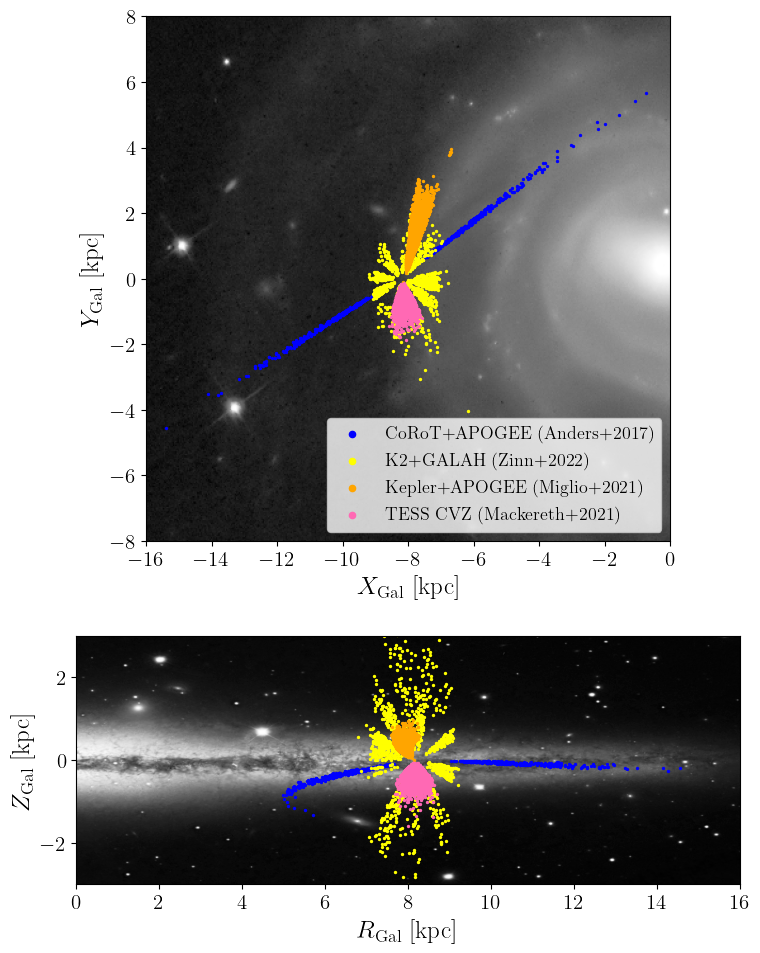

In [86]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[4, 2], figsize=(8,10))

# First fool the legend:
a0.scatter([-999.], [-999.], s=20, c="b", label="CoRoT+APOGEE (Anders+2017)")
a0.scatter([-999.], [-999.], s=20, c="yellow", label="K2+GALAH (Zinn+2022)")
a0.scatter([-999.], [-999.], s=20, c="orange", label="Kepler+APOGEE (Miglio+2021)")
a0.scatter([-999.], [-999.], s=20, c="hotpink", label="TESS CVZ (Mackereth+2021)")
a0.legend(loc="lower right", fontsize=13)

background = '../data/ugc12158_horizontal.png'
img = plt.imread(background)
a0.imshow(img[:, :, 0], zorder=0, extent=[-17, 10, -12, 12], cmap="Greys_r")
# Then plot the actual data
a0.scatter(-anders2017['Xg'],   anders2017['Yg'],   s=2, c="b")
a0.scatter(zinn2022['Xg'],     zinn2022['Yg'],     s=2, c="yellow")
a0.scatter(-np.cos(miglio2021['Galphi'])*(miglio2021['GalR']), 
           np.sin(miglio2021['Galphi'])*(miglio2021['GalR']),
           s=2, c="orange")
a0.scatter(mackereth2021['XGal'][mackereth2021["age_PARAM_BHM"]>0], 
            mackereth2021['YGal'][mackereth2021["age_PARAM_BHM"]>0], 
            s=2, c="hotpink")
a0.axis([-16, 0, -8, 8])
a0.set_xlabel(r"$X_{\rm Gal}$ [kpc]", fontsize=18)
a0.set_ylabel(r"$Y_{\rm Gal}$ [kpc]", fontsize=18)

background = '../data/ngc891_horizontal.png'
img = plt.imread(background)
print(img.shape)
a1.imshow(img[:, 622:, 0], zorder=0, extent=[0, 16, -3, 3], cmap="Greys_r")

a1.scatter(anders2017['Rg'],   anders2017['Zg'],   s=2, c="b", label="CoRoT+APOGEE (Anders+2017)")
a1.scatter(zinn2022['Rg'],     zinn2022['Zg'],     s=2, c="yellow", label="K2+GALAH (Zinn+2022)")
a1.scatter(miglio2021['GalR'], miglio2021['GalZ'], s=2, c="orange", label="Kepler+APOGEE (Miglio+2021)")
a1.scatter(mackereth2021['RGal'][mackereth2021["age_PARAM_BHM"]>0], 
            mackereth2021['ZGal'][mackereth2021["age_PARAM_BHM"]>0], 
            s=2, c="hotpink", label="TESS CVZ (Mackereth+2021)")
a1.axis([0, 16, -3, 3])
a1.set_xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
a1.set_ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)

plt.tight_layout()
plt.savefig("../im/XYRZ_allseismic_with_background.png", dpi=300)

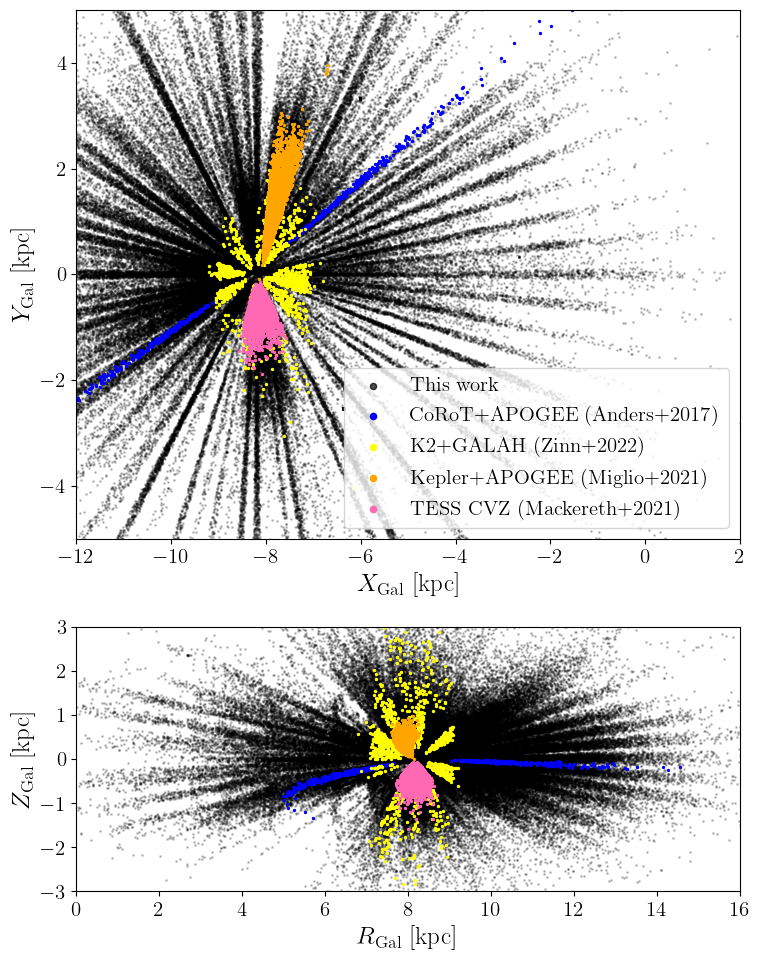

In [87]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[4, 2], figsize=(8,10))

# First fool the legend:
a0.scatter([-999.], [-999.], c="k", s=20, alpha=0.7, label="This work")
a0.scatter([-999.], [-999.], s=20, c="b", label="CoRoT+APOGEE (Anders+2017)")
a0.scatter([-999.], [-999.], s=20, c="yellow", label="K2+GALAH (Zinn+2022)")
a0.scatter([-999.], [-999.], s=20, c="orange", label="Kepler+APOGEE (Miglio+2021)")
a0.scatter([-999.], [-999.], s=20, c="hotpink", label="TESS CVZ (Mackereth+2021)")
a0.legend(loc="lower right", fontsize=15)

# Then plot the actual data
a0.scatter(-dr17_master['Xg'][chem_age], dr17_master['Yg'][chem_age], c="k", s=1, alpha=0.2)
a0.scatter(-anders2017['Xg'],   anders2017['Yg'],   s=2, c="b")
a0.scatter(zinn2022['Xg'],     zinn2022['Yg'],     s=2, c="yellow")
a0.scatter(-np.cos(miglio2021['Galphi'])*(miglio2021['GalR']), 
           np.sin(miglio2021['Galphi'])*(miglio2021['GalR']),
           s=2, c="orange")
a0.scatter(mackereth2021['XGal'][mackereth2021["age_PARAM_BHM"]>0], 
            mackereth2021['YGal'][mackereth2021["age_PARAM_BHM"]>0], 
            s=2, c="hotpink")
a0.axis([-12, 2, -5, 5])
a0.set_xlabel(r"$X_{\rm Gal}$ [kpc]", fontsize=18)
a0.set_ylabel(r"$Y_{\rm Gal}$ [kpc]", fontsize=18)


a1.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=0.2, label="APOGEE DR17 (This work)")
a1.scatter(anders2017['Rg'],   anders2017['Zg'],   s=2, c="b", label="CoRoT+APOGEE (Anders+2017)")
a1.scatter(zinn2022['Rg'],     zinn2022['Zg'],     s=2, c="yellow", label="K2+GALAH (Zinn+2022)")
a1.scatter(miglio2021['GalR'], miglio2021['GalZ'], s=2, c="orange", label="Kepler+APOGEE (Miglio+2021)")
a1.scatter(mackereth2021['RGal'][mackereth2021["age_PARAM_BHM"]>0], 
            mackereth2021['ZGal'][mackereth2021["age_PARAM_BHM"]>0], 
            s=2, c="hotpink", label="TESS CVZ (Mackereth+2021)")
a1.axis([0, 16, -3, 3])
a1.set_xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
a1.set_ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)

plt.tight_layout()
plt.savefig("../im/XYRZ_all_vs_others.png", dpi=300)

## Age uncertainty as a function of age

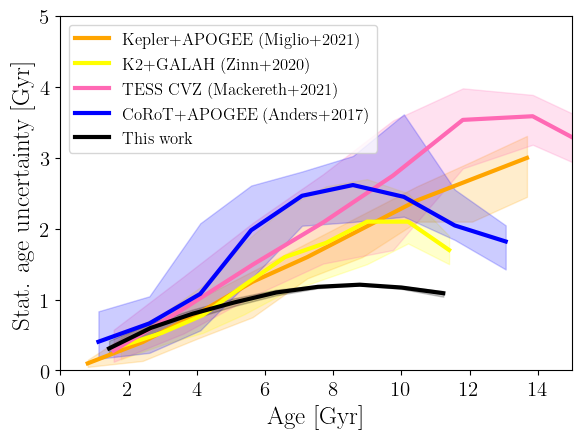

In [88]:
#Ages
plot_scatter = False

if plot_scatter:
    plt.scatter(-miglio2021['Age'], 0.5*(miglio2021['b_age_lc']-miglio2021['b_Age']), 
                c="orange", label="Kepler+APOGEE (Miglio+2021)", s=5)
    plt.scatter(-zinn2022['age'], zinn2022['e_age'],
                c="yellow", label="K2+GALAH (Zinn+2020)", s=5)
    plt.scatter(-mackereth2021['age_PARAM_BHM'][mackereth2021['age_PARAM_BHM']>0],
                0.5*(mackereth2021['age_68U_PARAM_BHM']-mackereth2021['age_68L_PARAM_BHM'])[mackereth2021['age_PARAM_BHM']>0],
                c="hotpink", label="TESS CVZ (Mackereth+2021)", s=5)
    plt.scatter(-anders2017['AgeM'], 0.5*(anders2017['AgeM68U']-anders2017['AgeM68L']),
                c="b", label="CoRoT+APOGEE (Anders+2017)", s=5)
else:
    overplot_trend(miglio2021['Age'], 0.5*(miglio2021['b_age_lc']-miglio2021['b_Age']), 
                   color="orange", alpha=0.2, bins=10, label="Kepler+APOGEE (Miglio+2021)")
    overplot_trend(zinn2022['age'], zinn2022['e_age'],
                   color="yellow", alpha=0.2, bins=10, label="K2+GALAH (Zinn+2020)")
    overplot_trend(mackereth2021['age_PARAM_BHM'][mackereth2021['age_PARAM_BHM']>0],
                   0.5*(mackereth2021['age_68U_PARAM_BHM']-mackereth2021['age_68L_PARAM_BHM'])[mackereth2021['age_PARAM_BHM']>0],
                   color="hotpink", alpha=0.2, bins=10, label="TESS CVZ (Mackereth+2021)")
    overplot_trend(anders2017['AgeM'], 0.5*(anders2017['AgeM68U']-anders2017['AgeM68L']), 
                   alpha=0.2, color="b", bins=10, label="CoRoT+APOGEE (Anders+2017)")
    overplot_trend(our_cat[agecol], our_cat[uncertcol], 
                   alpha=0.2, color="k", bins=10, label=r"This work")
#plt.title('Statistical age uncertainty vs. age')

plt.legend(loc="upper left", fontsize=12)
plt.axis([0,15,0,5])
plt.xlabel('Age [Gyr]', fontsize=18)
plt.ylabel(r"Stat. age uncertainty [Gyr]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/seismic_age_uncerts.png")

## Crossmatch each of those catalogues with our spectroscopic ages

In [89]:
# Our coordinates

our_coords  = SkyCoord(our_cat['RA'], our_cat['DEC'], 
                       unit=(u.deg, u.deg), frame="icrs")

In [90]:
# Zinn+2022 - filter before matching
zinn2022    = zinn2022[zinn2022['glon']>0.]
zinn_coords = SkyCoord(zinn2022['glon'], zinn2022['glat'], 
                       unit=(u.deg, u.deg), frame="galactic")
# idx_z = the indices into our_coords that get the closest matches in zinn_coords
idx_z, sep_z, _ = zinn_coords.match_to_catalog_sky(our_coords)

# Mackereth+2021 - filter before matching
mackereth2021 = mackereth2021[mackereth2021['age_PARAM_BHM']>0]
mack_coords   = SkyCoord(mackereth2021['l'], mackereth2021['b'], 
                         unit=(u.deg, u.deg), frame="galactic")
# idx_z = the indices into our_coords that get the closest matches in zinn_coords
idx_m, sep_m, _ = mack_coords.match_to_catalog_sky(our_coords)

# Anders+2017
anders_coords = SkyCoord(anders2017['GLON'], anders2017['GLAT'], 
                         unit=(u.deg, u.deg), frame="galactic")
# idx_z = the indices into our_coords that get the closest matches in zinn_coords
idx_a, sep_a, _ = anders_coords.match_to_catalog_sky(our_coords)

## Produce a comparison plot:

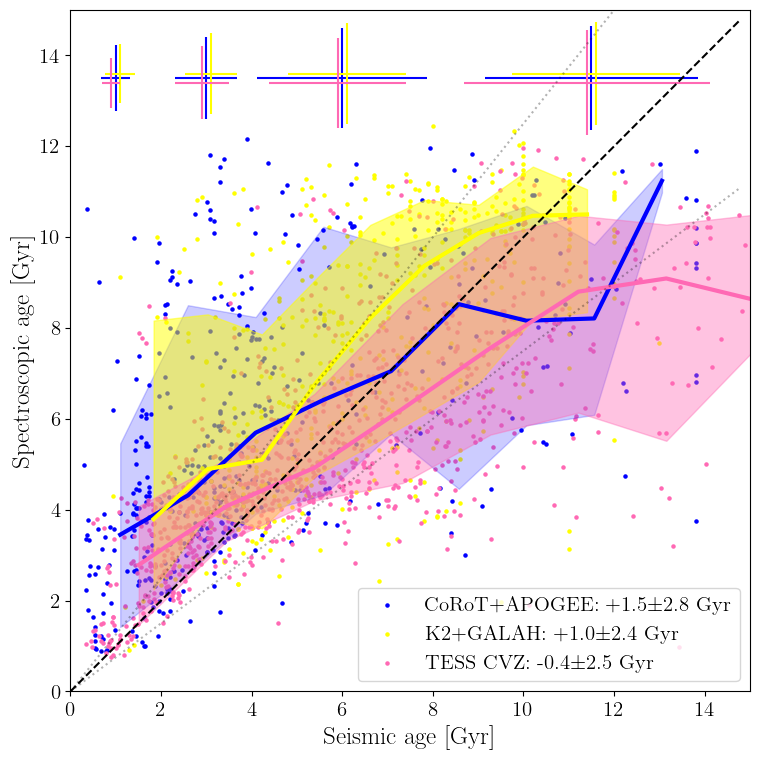

In [91]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

plot_scatter = True
    
diff_a17 = our_cat[agecol][idx_a][sep_a.arcsec<1]-anders2017['AgeM'][sep_a.arcsec<1]
diff_z22 = our_cat[agecol][idx_z][sep_z.arcsec<1]-zinn2022['age'][sep_z.arcsec<1]
diff_m21 = our_cat[agecol][idx_m][sep_m.arcsec<1]-mackereth2021['age_PARAM_BHM'][sep_m.arcsec<1]

text_a17 = str(np.round(np.mean(diff_a17),1)) + r"$\pm$" + str(np.round(np.std(diff_a17),1)) + r" Gyr"
text_z22 = str(np.round(np.mean(diff_z22),1)) + r"$\pm$" + str(np.round(np.std(diff_z22),1)) + r" Gyr"
text_m21 = str(np.round(np.mean(diff_m21),1)) + r"$\pm$" + str(np.round(np.std(diff_m21),1)) + r" Gyr"

# Scatter plots
if plot_scatter:
    # Anders+2017 - Only plot the matches with sep < 1 arcsec!
    plt.scatter(anders2017['AgeM'][sep_a.arcsec<1], 
                our_cat[agecol][idx_a][sep_a.arcsec<1],
                c="b", label="CoRoT+APOGEE: +"+text_a17, s=5)
    # Zinn+2022 - Only plot the matches with sep < 1 arcsec!
    plt.scatter(zinn2022['age'][sep_z.arcsec<1], 
                our_cat[agecol][idx_z][sep_z.arcsec<1],
                c="yellow", label="K2+GALAH: +"+text_z22, s=5)
    # Mackereth+2021 - Only plot the matches with sep < 1 arcsec!
    plt.scatter(mackereth2021['age_PARAM_BHM'][sep_m.arcsec<1], 
                our_cat[agecol][idx_m][sep_m.arcsec<1],
                c="hotpink", label="TESS CVZ: "+text_m21, s=5)

# Overplot the trends
overplot_trend(anders2017['AgeM'][sep_a.arcsec<1],
               our_cat[agecol][idx_a][sep_a.arcsec<1], 
               alpha=0.2, color="b", bins=10)
overplot_trend(zinn2022['age'][sep_z.arcsec<1],
               our_cat[agecol][idx_z][sep_z.arcsec<1],
               bins=10, alpha=0.5, color='yellow')
overplot_trend(mackereth2021['age_PARAM_BHM'][sep_m.arcsec<1],
               our_cat[agecol][idx_m][sep_m.arcsec<1],
               bins=10, alpha=0.4, color='hotpink')
plt.legend(loc="lower right", fontsize=15)

# Typical errorbars
age_ranges = [[0,2], [2,4], [4,8], [8,15]]
for ii in [0,1,2,3]:
    sel_a = (sep_a.arcsec<1) & (anders2017['AgeM'] > age_ranges[ii][0]) & (anders2017['AgeM'] < age_ranges[ii][1])
    xerr=np.median(0.5*(anders2017['AgeM68U'][sel_a]-anders2017['AgeM68L'][sel_a]))
    yerr=np.median(our_cat[uncertcol][idx_a][sel_a])
    plt.errorbar(0.5*(age_ranges[ii][0]+age_ranges[ii][1]), 13.5,
                 xerr=xerr, yerr=yerr, color="b")
    sel_z = (sep_z.arcsec<1) & (zinn2022['age'] > age_ranges[ii][0]) & (zinn2022['age'] < age_ranges[ii][1])
    xerr=np.median(zinn2022['e_age'][sel_z])
    yerr=np.median(our_cat[uncertcol][idx_z][sel_z])
    plt.errorbar(0.5*(age_ranges[ii][0]+age_ranges[ii][1])+.1, 13.5+.1,
                 xerr=xerr, yerr=yerr, color="yellow")
    sel_m = (sep_m.arcsec<1) & (mackereth2021['age_PARAM_BHM'] > age_ranges[ii][0]) & (mackereth2021['age_PARAM_BHM'] < age_ranges[ii][1])
    xerr=np.median(0.5*(mackereth2021['age_68U_PARAM_BHM'][sel_m]-mackereth2021['age_68L_PARAM_BHM'][sel_m]))
    yerr=np.median(our_cat[uncertcol][idx_m][sel_m])
    plt.errorbar(0.5*(age_ranges[ii][0]+age_ranges[ii][1])-.1, 13.5-.1,
                 xerr=xerr, yerr=yerr, color="hotpink")
    

plt.plot(np.arange(0,15,0.2),np.arange(0,15,0.2),'k--')
plt.plot(np.arange(0,15,0.2),0.75*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)
plt.plot(np.arange(0,15,0.2),1.25*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)

plt.axis([0,15,0,15])
plt.xlabel('Seismic age [Gyr]', fontsize=18)
if calib:
    plt.ylabel(r"Calibrated age [Gyr]", fontsize=18)
else:
    plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
plt.tight_layout()

if calib:
    plt.savefig("../im/seismic_age_calib_comp.png", dpi=300)
else:
    plt.savefig("../im/seismic_age_comp.png", dpi=300)

## Cantat-Gaudin+2020 open clusters

In [92]:
# Read Cantat+2020 tables
cg1 = Table.read("../data/CG2020.fit")
cg2 = Table.read("../data/CG2020members.fit")
# Join them
cg = join(cg2, cg1, keys="Cluster", join_type="left")
cg['GaiaDR2'].name = 'source_id'
cg = cg[cg["proba"] > 0.95] # only select >95% Pmemb

In [93]:
# Xmatch CG+2020 with our APOGEE cat
our_cat["source_id"] = our_cat["GaiaEDR3_sourceID"]
matched = join(our_cat[our_cat["source_id"]>0], cg, keys="source_id", join_type="inner")

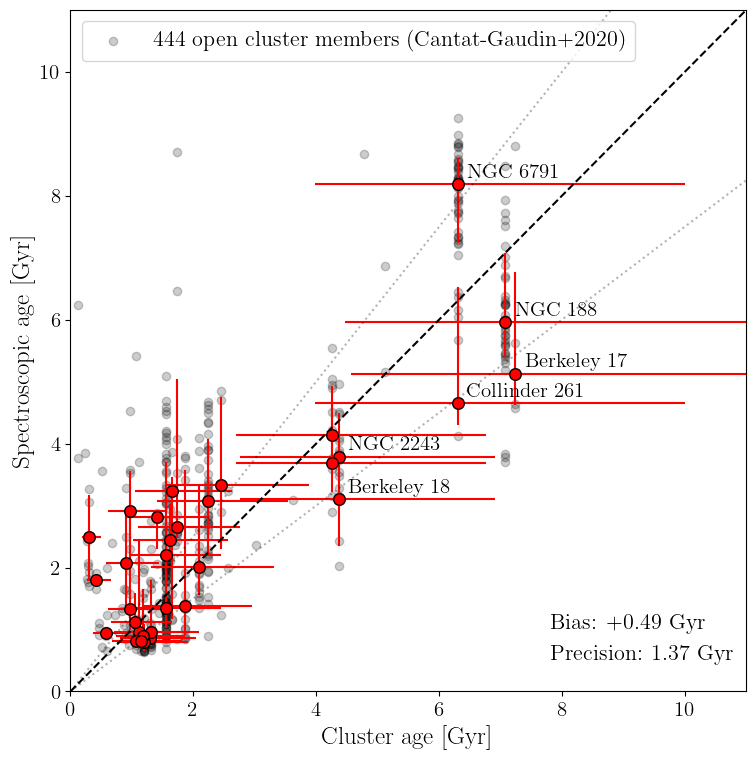

In [94]:
f, (ax) = plt.subplots(1, 1, figsize=(8,8))
# Individual stars
plt.scatter(10.**(matched["AgeNN"]-9), matched[agecol], 
            c="k", alpha=0.2, label=str(len(matched))+" open cluster members (Cantat-Gaudin+2020)")
plt.legend(loc="upper left", fontsize=16)

# Cluster averages
clusters = np.unique(matched["Cluster"])
for cc in clusters:
    if np.sum(matched["Cluster"]==cc) < 3:
        pass
    else:
        # Compute and plot median ages
        c = matched[ matched["Cluster"]==cc ]
        #print(cc, len(c))
        plt.errorbar(10.**(c["AgeNN"][0]-9), np.median(c[agecol]), 
                     xerr=[[10.**(c["AgeNN"][0]-9)-10.**(c["AgeNN"][0]-9-0.2)], 
                           [10.**(c["AgeNN"][0]-9+0.2)-10.**(c["AgeNN"][0]-9)]], 
                     yerr=[ [np.median(c[agecol])- np.percentile(c[agecol], 16)], 
                            [-np.median(c[agecol])+ np.percentile(c[agecol], 84)]],
                     c="r", ms=20, mec="k")
        plt.scatter(10.**(c["AgeNN"][0]-9), np.median(c[agecol]), 
                    alpha=1,c="r", s=70, zorder=5, ec="k")
        if 10.**(c["AgeNN"][0]-9) > 4.3:
            ax.text(10.**(c["AgeNN"][0]-9)+.15,
                    np.percentile(c[agecol], 50)+.1,
                    cc.replace("_", " "), zorder=6, fontsize=15)
plt.axis([0,11,0,11])
plt.plot(np.arange(0,15,0.2),np.arange(0,15,0.2),'k--')
plt.plot(np.arange(0,15,0.2),0.75*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)
plt.plot(np.arange(0,15,0.2),1.25*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)
plt.xlabel('Cluster age [Gyr]', fontsize=18)
if calib:
    plt.ylabel(r"Calibrated age [Gyr]", fontsize=18)
else:
    plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
    
plt.text(7.8, 1, "Bias: +"+ str(np.round(np.mean(matched[agecol]-10.**(matched["AgeNN"]-9)),2))+ " Gyr", 
         fontsize=16)
plt.text(7.8, 0.5, "Precision: "+ str(np.round(np.std(matched[agecol]-10.**(matched["AgeNN"]-9)),2))+ " Gyr", 
         fontsize=16)

plt.tight_layout()

if calib:
    plt.savefig("../im/cluster_age_calib_comp.png", dpi=300)
else:
    plt.savefig("../im/cluster_age_comp.png", dpi=300)


## Comparison to StarHorse ages (computed but not published in Queiroz+2023)

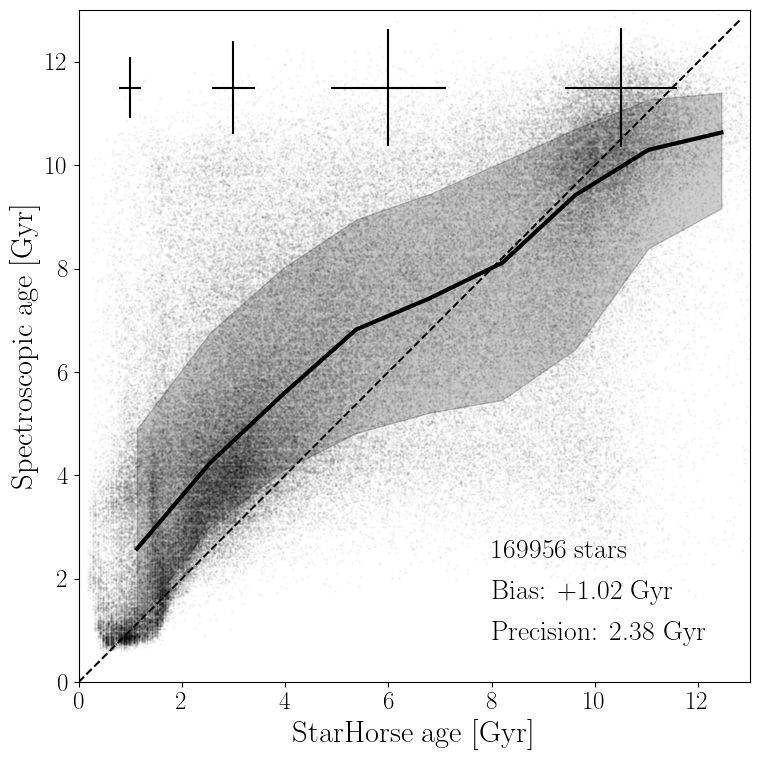

In [95]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

plt.scatter( our_cat["age50"], our_cat[agecol],
            c="k", s=1, alpha=0.03)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(our_cat["age50"], our_cat[agecol], 
               alpha=0.2, color="k", bins=10)

plt.plot(np.arange(0,13,0.2),np.arange(0,13,0.2),'k--')

# Add typical errorbars
overplot_representative_errorbars(our_cat["age50"], our_cat[agecol], 
                                  0.5*(our_cat["age84"]-our_cat["age16"]), our_cat[uncertcol], 
                                  age_ranges = [[0,2], [2,4], [4,8], [8,13]], 
                                  y_plot=11.5, c="k")

plt.axis([0,13,0,13])
plt.xlabel(r"StarHorse age [Gyr]", fontsize=22)
if calib:
    plt.ylabel(r"Calibrated age [Gyr]", fontsize=22)
else:
    plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.text(8, 2.4, str(len(our_cat))+ " stars", fontsize=20)
plt.text(8, 1.6, "Bias: +"+ str(np.round(np.mean(our_cat[agecol]-our_cat["age50"]),2))+ " Gyr", fontsize=20)
plt.text(8, 0.8, "Precision: "+ str(np.round(np.std(our_cat[agecol]-our_cat["age50"]),2))+ " Gyr", fontsize=20)

plt.tight_layout()
if calib:
    plt.savefig("../im/starhorse_age_calib_comp.png", dpi=300)
else:
    plt.savefig("../im/starhorse_age_comp.png", dpi=300)

## Comparison to [C/N] ages (Hasselquist+2022)?

In [69]:
# Read Hasselquist+2022 table
has = Table.read("../data/Hasselquist2022.fit")
has["APOGEE_ID"] = has["ID"]

In [70]:
our = Table.read("../data/spec_ages_feb2023.fits")
our_has = join(our, has, keys="APOGEE_ID", join_type="inner")
our_has

APOGEE_ID,spec_age_feb2023,spec_age_feb2023_calib,spec_age_feb2023_uncert,ID,logAge,e_logAge,_RA,_DE
,,,,,log(yr),log(yr),deg,deg
bytes18,float32,float32,float32,bytes18,float64,float64,float64,float64


Okay, as expected, there is no overlap with the sample of Hasselquist+2022 :(

## Comparison to DR17 astroNN ages (Leung+2019) 

In [96]:
# Read APOGEE DR17 astroNN table
nn = Table.read("../data/apogee_astroNN-DR17_small.fits")
nn

APOGEE_ID,age,age_linear_correct,age_lowess_correct,age_total_error,age_model_error,galr,galphi,galz,galvr,galvt,galvz,e,e_err,zmax,zmax_err,jr,Lz,jz
bytes18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2M00000068+5710233,6.4748053550720215,7.029122352600098,6.705513518649095,1.2569321122858375,1.1139900803540859,8.46098987388082,0.07566320991141692,-0.0406847367394501,8.405771449811779,225.96059829727088,-37.62047772723712,0.05609452258216031,0.0004446731159886344,0.7428875425769231,0.0161604061982705,3.9792944836978883,1912.8630234292718,12.408570402042907
2M00000133+5721163,4.585171222686768,4.8993144035339355,4.6335312182356825,2.29691775581396,1.1173288065802893,11.682157335777642,0.4414582416917462,-0.44171064595380416,-0.5992426970112879,184.67570697556053,30.99258317200076,0.12178279291987276,0.0071389382789339385,1.1626661970148564,0.05983861868834254,21.81053536366464,2173.6507323308947,19.329764820268586
2M00000211+6327470,1.9954009056091309,1.9803822040557861,1.9575280414355773,0.7246207767957537,0.24115528719385873,11.4322853636099,0.4115344193908144,0.1311313612041843,-10.979024446432446,184.70799662190691,-12.362535072137549,0.15793373596153237,0.017657175377035327,0.3294014279368765,0.06161900337184913,35.646640400780626,2092.3806384020118,2.2372161839536746
2M00000222+5625359,2.3454275131225586,2.3748974800109863,2.3148725522321163,0.814782314790626,0.7375020904292033,9.20887811443118,0.20227576214558432,-0.1833133625406289,-3.5404591711088362,216.2209755283072,-16.58899037138947,0.011775203511935561,0.0019002318305154254,0.3603105163438902,0.018134780547359144,0.18619021865127802,1994.8003871102146,3.48250980665096
2M00000446+5854329,2.9034950733184814,3.0038957595825195,2.88489450372465,0.6174448664948793,0.36450784435154837,10.563598502080753,0.3505781312397918,-0.20824851750806442,6.477925705049042,231.99497854718996,-3.8414482112949826,0.11509239406714673,0.013850582841889994,0.26929352555550634,0.031303388013420114,22.52085246163461,2480.2875980485937,1.2404013737457227
2M00000506+5656353,2.478800058364868,2.525221824645996,2.4510530024051658,1.2746845027074718,0.675334566504731,8.629041186665209,0.10821344633106852,-0.0727581442357221,24.729873886018755,242.62705796252385,-9.120834830290168,0.1537609633077803,0.00139365889256538,0.1898086121979445,0.0229137973052086,33.726554754589756,2100.4636613938624,0.7939268014946835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2M23595669+6131251,7.37332820892334,8.041847229003906,7.70296530580531,1.8891794255423213,1.4302164959036119,9.836789348191168,0.27376783079138806,-0.014098916594671562,38.920546487410036,220.91863676842945,7.3334636019053585,0.13945757870033476,0.005877938495731883,0.1492970041618676,0.004538391351484855,28.653264916266213,2174.9765392657864,0.483543548672345
2M23595676+7918072,1.1104130744934082,0.9829118251800537,1.0542296500637998,0.8434031942301369,0.4767304918614283,9.400150775044333,0.19879617577014036,0.6688234688928,67.63325109668445,152.8704607965727,41.54881966227118,0.395475381391492,0.014389651653272042,1.4229209149389168,0.0839325025460845,175.89073246344844,1391.337370384836,29.02408659839702


In [97]:
our = Table.read("../data/spec_ages_published.fits")
our_nn = join(our, nn, keys="APOGEE_ID", join_type="inner")

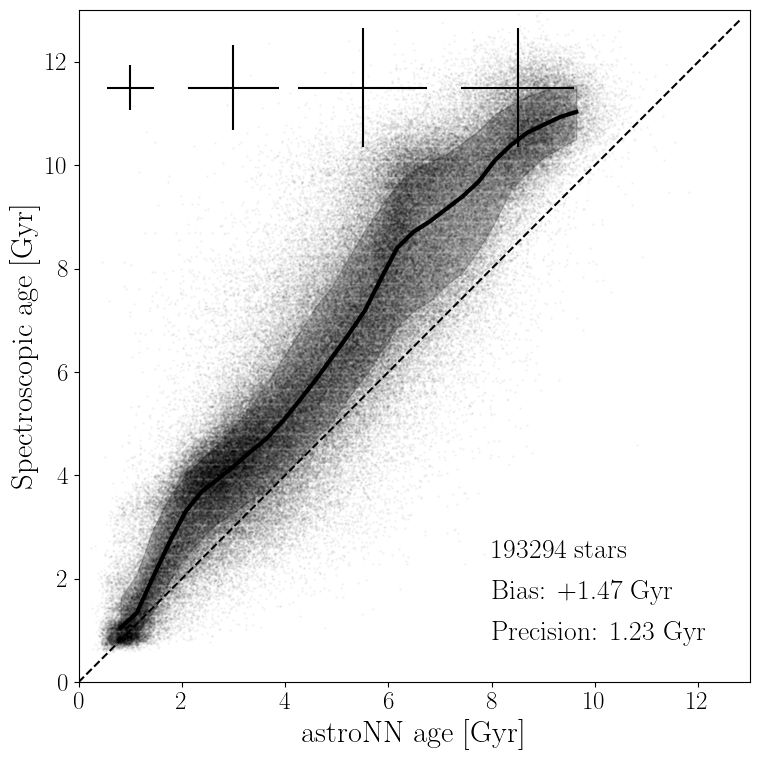

In [98]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

plt.scatter(our_nn["age"], our_nn[agecol], 
            c="k", s=1, alpha=0.03)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(our_nn["age"], our_nn[agecol], 
               alpha=0.2, color="k", bins=30)
# Add typical errorbars
overplot_representative_errorbars(our_nn["age"], our_nn[agecol], 
                                  our_nn["age_total_error"], our_nn[uncertcol], 
                                  age_ranges = [[0,2], [2,4], [4,7], [7,10]], 
                                  y_plot=11.5, c="k")

plt.plot(np.arange(0,13,0.2),np.arange(0,13,0.2),'k--')

plt.text(8, 2.4, str(len(our_nn))+ " stars", fontsize=20)
plt.text(8, 1.6, "Bias: +"+ str(np.round(np.mean(our_nn[agecol]-our_nn["age"]),2))+ " Gyr", fontsize=20)
plt.text(8, 0.8, "Precision: "+ str(np.round(np.std(our_nn[agecol]-our_nn["age"]),2))+ " Gyr", fontsize=20)

plt.axis([0,13,0,13])
plt.xlabel(r"astroNN age [Gyr]", fontsize=22)
if calib:
    plt.ylabel(r"Calibrated age [Gyr]", fontsize=22)
else:
    plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
if calib:
    plt.savefig("../im/astronn_age_calib_comp.png", dpi=300)
else:
    plt.savefig("../im/astronn_age_comp.png", dpi=300)

## Comparison to Spoo+2022 [C/N] ages

As per their paper:

* log[Age(yr)]DR17 = 10.14(±0.08) + 2.23(±0.19) * [C/N]

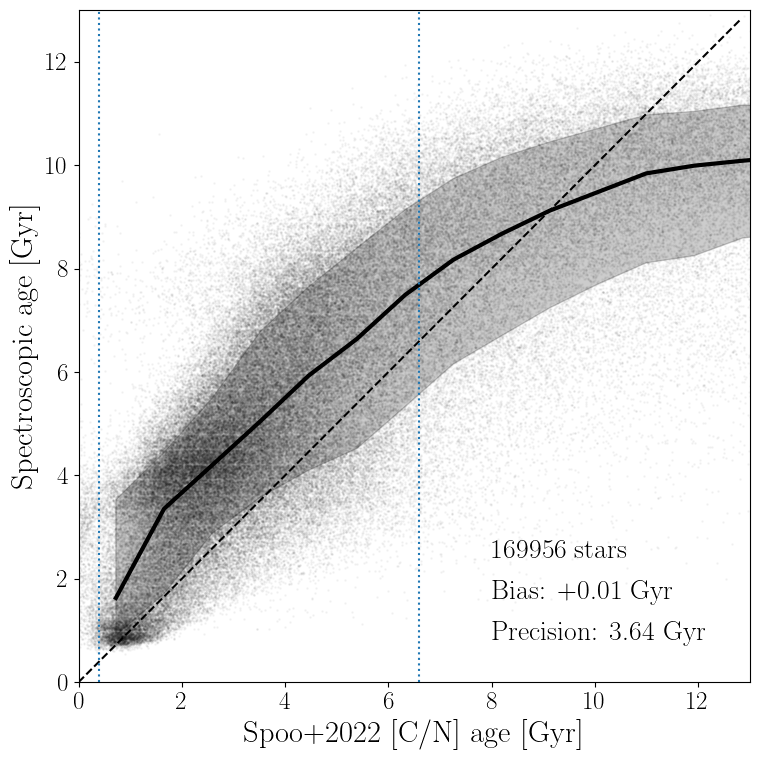

In [99]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

spoo_age_gyr = 10.**(1.14 + 2.23 * (our_cat["C_FE"]-our_cat["N_FE"]))

plt.scatter(spoo_age_gyr, our_cat[agecol], 
            c="k", s=1, alpha=0.03)
overplot_trend(spoo_age_gyr, our_cat[agecol], 
               alpha=0.2, color="k", bins=30)

plt.plot(np.arange(0,13,0.2),np.arange(0,13,0.2),'k--')
plt.vlines([0.4, 6.6], ymin=0, ymax=15, ls="dotted")


plt.text(8, 2.4, str(len(our_cat))+ " stars", fontsize=20)
plt.text(8, 1.6, "Bias: +"+ str(np.round(np.mean(our_cat[agecol]-spoo_age_gyr),2))+ " Gyr", fontsize=20)
plt.text(8, 0.8, "Precision: "+ str(np.round(np.std(our_cat[agecol]-spoo_age_gyr),2))+ " Gyr", fontsize=20)

#plt.legend(loc="upper left", fontsize=15)
plt.axis([0,13,0,13])
plt.xlabel(r"Spoo+2022 [C/N] age [Gyr]", fontsize=22)
if calib:
    plt.ylabel(r"Calibrated age [Gyr]", fontsize=22)
else:
    plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
if calib:
    plt.savefig("../im/spoo_cn_age_calib_comp.png", dpi=300)
else:
    plt.savefig("../im/spoo_cn_age_comp.png", dpi=300)

## Comparison to Leung+2023 (variational auto-encoder + random forest)

In [100]:
leung2023 = Table.read("../data/nn_latent_age_dr17_feb2023.fits")
our_leung = join(our, leung2023, keys="APOGEE_ID", join_type="inner")

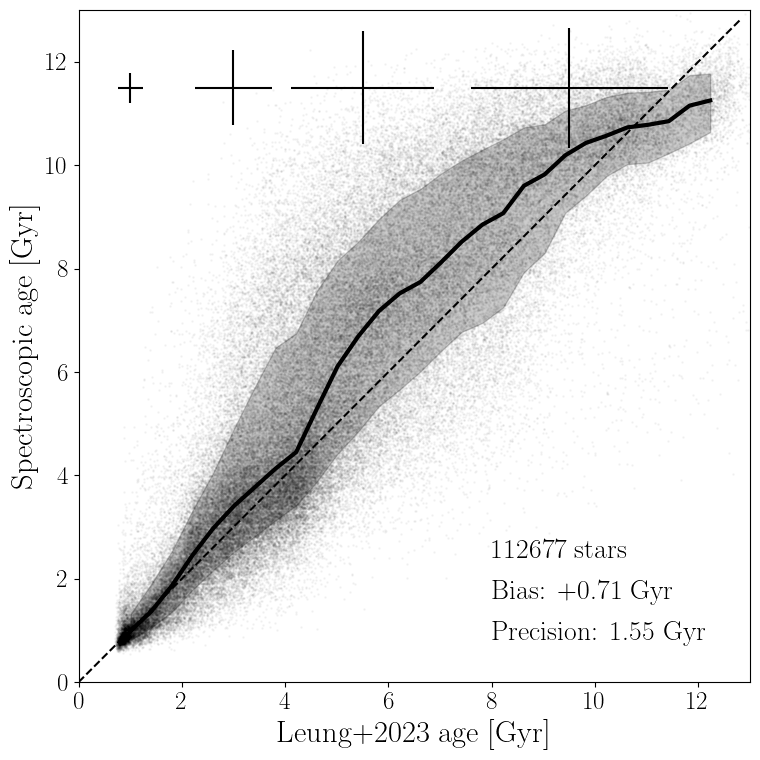

In [101]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

plt.scatter(our_leung["Age"], our_leung[agecol], 
            c="k", s=1, alpha=0.03)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(our_leung["Age"], our_leung[agecol], 
               alpha=0.2, color="k", bins=30)
# Add typical errorbars
overplot_representative_errorbars(our_leung["Age"], our_leung[agecol], 
                                  our_leung["Age_Error"], our_leung[uncertcol], 
                                  age_ranges = [[0,2], [2,4], [4,7], [7,12]], 
                                  y_plot=11.5, c="k")

plt.plot(np.arange(0,13,0.2),np.arange(0,13,0.2),'k--')

plt.text(8, 2.4, str(len(our_leung))+ " stars", fontsize=20)
plt.text(8, 1.6, "Bias: +"+ str(np.round(np.mean(our_leung[agecol]-our_leung["Age"]),2))+ " Gyr", fontsize=20)
plt.text(8, 0.8, "Precision: "+ str(np.round(np.std(our_leung[agecol]-our_leung["Age"]),2))+ " Gyr", fontsize=20)

#plt.legend(loc="upper left", fontsize=15)
plt.axis([0,13,0,13])
plt.xlabel(r"Leung+2023 age [Gyr]", fontsize=22)
if calib:
    plt.ylabel(r"Calibrated age [Gyr]", fontsize=22)
else:
    plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
if calib:
    plt.savefig("../im/leung2023_age_calib_comp.png", dpi=300)
else:
    plt.savefig("../im/leung2023_age_comp.png", dpi=300)

## Comparison to Ciuca+2022 (BINGO)

In [102]:
ciuca2022 = Table.read("../data/APOGEE_DR17_bingoages_conservative_age_cut.fits")
our_ciuca = join(our, ciuca2022[np.isfinite(ciuca2022['age_total_error'])], keys="APOGEE_ID", join_type="inner")

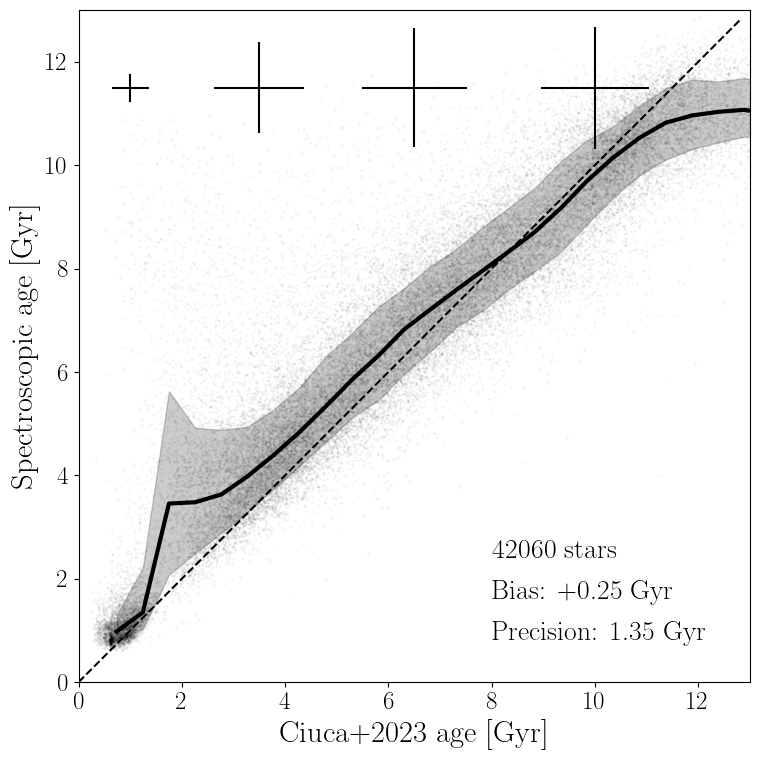

In [103]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

plt.scatter(our_ciuca["age"], our_ciuca[agecol], 
            c="k", s=1, alpha=0.03)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(our_ciuca["age"], our_ciuca[agecol], 
               alpha=0.2, color="k", bins=30)
# Add typical errorbars
overplot_representative_errorbars(our_ciuca["age"], our_ciuca[agecol], 
                                  our_ciuca["age_total_error"], our_ciuca[uncertcol], 
                                  age_ranges = [[0,2], [2,5], [5,8], [8,12]], 
                                  y_plot=11.5, c="k")

plt.plot(np.arange(0,13,0.2),np.arange(0,13,0.2),'k--')

plt.text(8, 2.4, str(len(our_ciuca))+ " stars", fontsize=20)
plt.text(8, 1.6, "Bias: +"+ str(np.round(np.mean(our_ciuca[agecol]-our_ciuca["age"]),2))+ " Gyr", fontsize=20)
plt.text(8, 0.8, "Precision: "+ str(np.round(np.std(our_ciuca[agecol]-our_ciuca["age"]),2))+ " Gyr", fontsize=20)

#plt.legend(loc="upper left", fontsize=15)
plt.axis([0,13,0,13])
plt.xlabel(r"Ciuca+2023 age [Gyr]", fontsize=22)
if calib:
    plt.ylabel(r"Calibrated age [Gyr]", fontsize=22)
else:
    plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
if calib:
    plt.savefig("../im/ciuca2022_age_calib_comp.png", dpi=300)
else:
    plt.savefig("../im/ciuca2022_age_comp.png", dpi=300)